# This notebook analyses the effects of the W-NET's Height and Width on the reconstrucion results on the Bidmc database


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.stats import kurtosis, skew
import pywt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from models.ecg2ppg_model_depth import ECG2PPGps, create_windows, ECG2PPGps_loss
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse
from scipy.signal import butter, filtfilt, medfilt
import random

In [2]:
# ---- PARAMETERS ----
FS = 125
WINDOW_SIZE_SEC = 8.192
STEP_SIZE_SEC = 2.048

# ---- BASELINE REMOVAL ----
def remove_baseline_median(signal, fs, window_sec=1.5):
    kernel_size = int(window_sec * fs)
    if kernel_size % 2 == 0:
        kernel_size += 1
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def remove_baseline_wavelet(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    return pywt.waverec(coeffs, wavelet)[:len(signal)]

# ---- WINDOWING ----
def create_windows(signal, win_size, step_size):
    return np.array([
        signal[start:start + win_size]
        for start in range(0, len(signal) - win_size + 1, step_size)
    ])

# ---- LOAD DATA ----
def load_signals(file_path):
    df = pd.read_csv(file_path)
    df.columns = [c.strip() for c in df.columns]
    if 'II' not in df.columns or 'PLETH' not in df.columns:
        return None, None
    ecg = df['II'].values
    ppg = df['PLETH'].values
    return ecg, ppg


In [3]:
# --- Parameters ---
window_length = 1024
stride = 256
maxEpochs = 500
batchSize = 128
fs = 125
depths = [2, 4, 6, 8]
random_subjects = random.sample(range(1, 54), 5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for idx in random_subjects:
    file_idx = f"{idx:02d}"
    file_path = f"bidmc_csv/bidmc_{file_idx}_Signals.csv"

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"\n🔵 Processing Subject {file_idx}...")

    try:
        datafile = pd.read_csv(file_path)
        datafile = datafile[['Time [s]', ' II', ' PLETH']]

        ecg = datafile[' II'].to_numpy()
        ecg = remove_baseline_wavelet(ecg)
        ppg = datafile[' PLETH'].to_numpy()
        ppg = remove_baseline_median(ppg, fs)

        if len(ecg) == 0 or len(ppg) == 0 or len(ecg) != len(ppg):
            print(f"Skipping subject {file_idx} due to invalid signals.")
            continue

        ecg_windows = create_windows(ecg, window_length, stride)
        ppg_windows = create_windows(ppg, window_length, stride)

        if len(ecg_windows[-1]) != window_length:
            ecg_windows = ecg_windows[:-1]
        if len(ppg_windows[-1]) != window_length:
            ppg_windows = ppg_windows[:-1]

        num_windows = len(ecg_windows)
        split_idx = int(0.8 * num_windows)
        ecg_train, ecg_test = ecg_windows[:split_idx], ecg_windows[split_idx:]
        ppg_train, ppg_test = ppg_windows[:split_idx], ppg_windows[split_idx:]

        train_dataset = TensorDataset(
            torch.tensor(ppg_train, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_train, dtype=torch.float32).unsqueeze(1)
        )
        test_dataset = TensorDataset(
            torch.tensor(ppg_test, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_test, dtype=torch.float32).unsqueeze(1)
        )

        train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

        for depth in depths:
            print(f"Training Subject {file_idx} with Depth {depth}...")

            # --- Initialize model ---
            model = ECG2PPGps(in_channels=1, out_channels=1, depth=depth).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)

            # --- Training ---
            for epoch in range(maxEpochs):
                model.train()
                for input_batch, target_batch in tqdm(train_loader, desc=f"Subj {file_idx} Depth {depth} Epoch {epoch+1}", unit="batch", leave=False):
                    input_batch = input_batch.to(device)
                    target_batch = target_batch.to(device)

                    output_batch = model(input_batch)
                    loss = ECG2PPGps_loss(output_batch, target_batch)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            # --- Save model ---
            model_dir = f"subject_models_depth_{depth}"
            os.makedirs(model_dir, exist_ok=True)
            model_save_path = os.path.join(model_dir, f"subject_{file_idx}_model.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"💾 Model saved: {model_save_path}")

            # --- Evaluation ---
            model.eval()
            pearson_list = []
            rmse_list = []

            with torch.no_grad():
                for input_batch, target_batch in test_loader:
                    input_batch = input_batch.to(device)
                    output_batch = model(input_batch)

                    output_batch = output_batch.squeeze(1).cpu().numpy()
                    target_batch = target_batch.squeeze(1).cpu().numpy()

                    for i in range(len(output_batch)):
                        pearson = compute_pearson(target_batch[i], output_batch[i])
                        rmse = compute_rmse(target_batch[i], output_batch[i])
                        pearson_list.append(pearson)
                        rmse_list.append(rmse)

            eval_df = pd.DataFrame({
                'Window': np.arange(len(pearson_list)),
                'Pearson_r': pearson_list,
                'RMSE': rmse_list
            })

            eval_save_path = os.path.join(model_dir, f"subject_{file_idx}_evaluation.csv")
            eval_df.to_csv(eval_save_path, index=False)
            print(f"💾 Evaluation saved: {eval_save_path}")

    except Exception as e:
        print(f"❌ Error processing Subject {file_idx}: {e}")


Using device: cuda

🔵 Processing Subject 09...
Training Subject 09 with Depth 2...


💾 Model saved: subject_models_depth_2\subject_09_model.pth
💾 Evaluation saved: subject_models_depth_2\subject_09_evaluation.csv
Training Subject 09 with Depth 4...


💾 Model saved: subject_models_depth_4\subject_09_model.pth
💾 Evaluation saved: subject_models_depth_4\subject_09_evaluation.csv
Training Subject 09 with Depth 6...


💾 Model saved: subject_models_depth_6\subject_09_model.pth
💾 Evaluation saved: subject_models_depth_6\subject_09_evaluation.csv
Training Subject 09 with Depth 8...


💾 Model saved: subject_models_depth_8\subject_09_model.pth
💾 Evaluation saved: subject_models_depth_8\subject_09_evaluation.csv

🔵 Processing Subject 25...
Training Subject 25 with Depth 2...


💾 Model saved: subject_models_depth_2\subject_25_model.pth
💾 Evaluation saved: subject_models_depth_2\subject_25_evaluation.csv
Training Subject 25 with Depth 4...


💾 Model saved: subject_models_depth_4\subject_25_model.pth
💾 Evaluation saved: subject_models_depth_4\subject_25_evaluation.csv
Training Subject 25 with Depth 6...


💾 Model saved: subject_models_depth_6\subject_25_model.pth
💾 Evaluation saved: subject_models_depth_6\subject_25_evaluation.csv
Training Subject 25 with Depth 8...


💾 Model saved: subject_models_depth_8\subject_25_model.pth
💾 Evaluation saved: subject_models_depth_8\subject_25_evaluation.csv

🔵 Processing Subject 32...
Training Subject 32 with Depth 2...


💾 Model saved: subject_models_depth_2\subject_32_model.pth
💾 Evaluation saved: subject_models_depth_2\subject_32_evaluation.csv
Training Subject 32 with Depth 4...


💾 Model saved: subject_models_depth_4\subject_32_model.pth
💾 Evaluation saved: subject_models_depth_4\subject_32_evaluation.csv
Training Subject 32 with Depth 6...


💾 Model saved: subject_models_depth_6\subject_32_model.pth
💾 Evaluation saved: subject_models_depth_6\subject_32_evaluation.csv
Training Subject 32 with Depth 8...


💾 Model saved: subject_models_depth_8\subject_32_model.pth
💾 Evaluation saved: subject_models_depth_8\subject_32_evaluation.csv

🔵 Processing Subject 53...
Training Subject 53 with Depth 2...


💾 Model saved: subject_models_depth_2\subject_53_model.pth
💾 Evaluation saved: subject_models_depth_2\subject_53_evaluation.csv
Training Subject 53 with Depth 4...


💾 Model saved: subject_models_depth_4\subject_53_model.pth
💾 Evaluation saved: subject_models_depth_4\subject_53_evaluation.csv
Training Subject 53 with Depth 6...


💾 Model saved: subject_models_depth_6\subject_53_model.pth
💾 Evaluation saved: subject_models_depth_6\subject_53_evaluation.csv
Training Subject 53 with Depth 8...


💾 Model saved: subject_models_depth_8\subject_53_model.pth
💾 Evaluation saved: subject_models_depth_8\subject_53_evaluation.csv

🔵 Processing Subject 37...
Training Subject 37 with Depth 2...


💾 Model saved: subject_models_depth_2\subject_37_model.pth
💾 Evaluation saved: subject_models_depth_2\subject_37_evaluation.csv
Training Subject 37 with Depth 4...


💾 Model saved: subject_models_depth_4\subject_37_model.pth
💾 Evaluation saved: subject_models_depth_4\subject_37_evaluation.csv
Training Subject 37 with Depth 6...


💾 Model saved: subject_models_depth_6\subject_37_model.pth
💾 Evaluation saved: subject_models_depth_6\subject_37_evaluation.csv
Training Subject 37 with Depth 8...


💾 Model saved: subject_models_depth_8\subject_37_model.pth
💾 Evaluation saved: subject_models_depth_8\subject_37_evaluation.csv


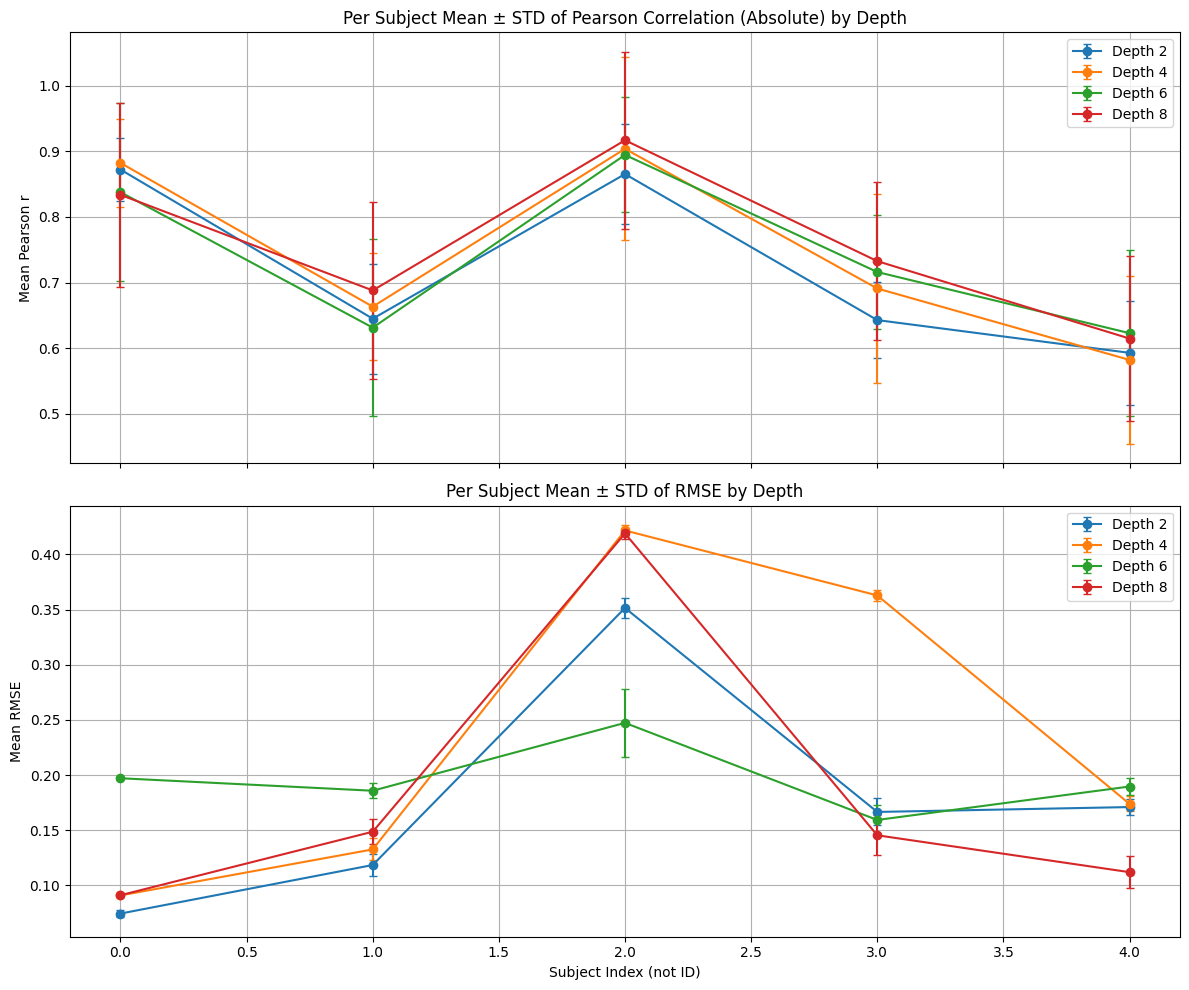

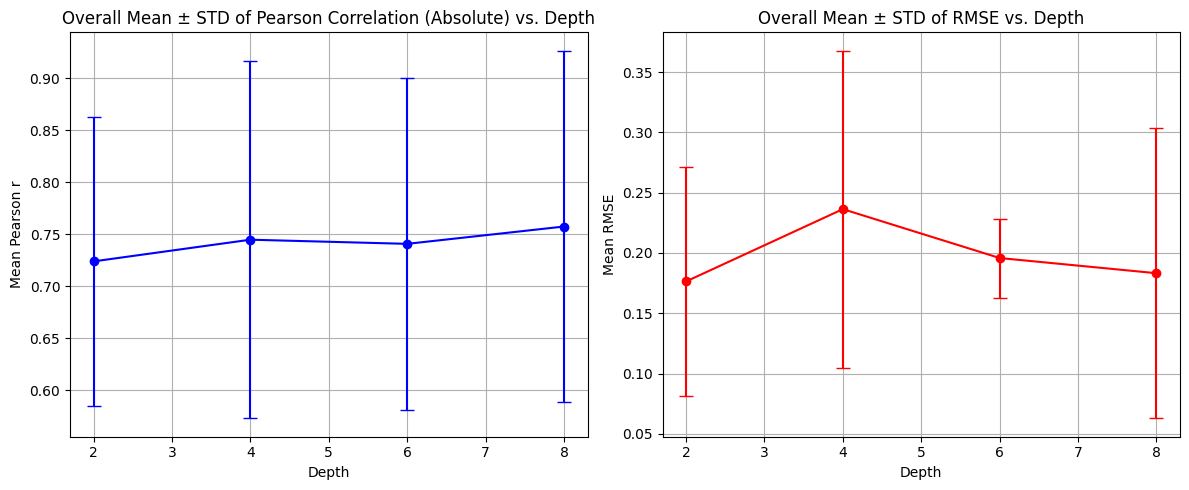

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
eval_base_dir = "."  # directory containing subject_models_depth_{X}
depths = [2, 4, 6, 8]
subjects = range(1, 54)

# --- Containers ---
subject_corr_stats = {depth: [] for depth in depths}
subject_rmse_stats = {depth: [] for depth in depths}
global_corr_stats = []
global_rmse_stats = []

# --- Collect Data ---
for depth in depths:
    eval_dir = f"subject_models_depth_{depth}"
    all_corrs = []
    all_rmses = []

    for sid in subjects:
        eval_path = os.path.join(eval_dir, f"subject_{sid:02d}_evaluation.csv")
        if not os.path.exists(eval_path):
            continue

        df = pd.read_csv(eval_path)
        if "Pearson_r" not in df.columns or "RMSE" not in df.columns:
            continue

        corr_values = np.abs(df["Pearson_r"].dropna().values)
        rmse_values = df["RMSE"].dropna().values

        if len(corr_values) > 0:
            subject_corr_stats[depth].append([np.mean(corr_values), np.std(corr_values)])
            all_corrs.extend(corr_values)

        if len(rmse_values) > 0:
            subject_rmse_stats[depth].append([np.mean(rmse_values), np.std(rmse_values)])
            all_rmses.extend(rmse_values)

    # Collect global mean/std
    global_corr_stats.append([np.mean(all_corrs), np.std(all_corrs)])
    global_rmse_stats.append([np.mean(all_rmses), np.std(all_rmses)])

# --- Plot 1: Per-Subject Correlation and RMSE ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for depth in depths:
    means_corr = [s[0] for s in subject_corr_stats[depth]]
    stds_corr = [s[1] for s in subject_corr_stats[depth]]
    axs[0].errorbar(range(len(means_corr)), means_corr, yerr=stds_corr, label=f"Depth {depth}", fmt='o-', capsize=3)

    means_rmse = [s[0] for s in subject_rmse_stats[depth]]
    stds_rmse = [s[1] for s in subject_rmse_stats[depth]]
    axs[1].errorbar(range(len(means_rmse)), means_rmse, yerr=stds_rmse, label=f"Depth {depth}", fmt='o-', capsize=3)

axs[0].set_title("Per Subject Mean ± STD of Pearson Correlation (Absolute) by Depth")
axs[0].set_ylabel("Mean Pearson r")
axs[0].legend()
axs[0].grid(True)

axs[1].set_title("Per Subject Mean ± STD of RMSE by Depth")
axs[1].set_xlabel("Subject Index (not ID)")
axs[1].set_ylabel("Mean RMSE")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# --- Plot 2: Global Summary of Depths ---
depth_labels = [str(d) for d in depths]
corr_means = [g[0] for g in global_corr_stats]
corr_stds = [g[1] for g in global_corr_stats]
rmse_means = [g[0] for g in global_rmse_stats]
rmse_stds = [g[1] for g in global_rmse_stats]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].errorbar(depths, corr_means, yerr=corr_stds, fmt='o-', capsize=5, color='blue')
axs[0].set_title("Overall Mean ± STD of Pearson Correlation (Absolute) vs. Depth")
axs[0].set_xlabel("Depth")
axs[0].set_ylabel("Mean Pearson r")
axs[0].grid(True)

axs[1].errorbar(depths, rmse_means, yerr=rmse_stds, fmt='o-', capsize=5, color='red')
axs[1].set_title("Overall Mean ± STD of RMSE vs. Depth")
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Mean RMSE")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Using device: cuda

🔵 Processing Subject 04...
Training Subject 04 with Width 1...


💾 Model saved: subject_models_convs_1\subject_04_model.pth
💾 Evaluation saved: subject_models_convs_1\subject_04_evaluation.csv
Training Subject 04 with Width 2...


💾 Model saved: subject_models_convs_2\subject_04_model.pth
💾 Evaluation saved: subject_models_convs_2\subject_04_evaluation.csv
Training Subject 04 with Width 3...


💾 Model saved: subject_models_convs_3\subject_04_model.pth
💾 Evaluation saved: subject_models_convs_3\subject_04_evaluation.csv

🔵 Processing Subject 16...
Training Subject 16 with Width 1...


💾 Model saved: subject_models_convs_1\subject_16_model.pth
💾 Evaluation saved: subject_models_convs_1\subject_16_evaluation.csv
Training Subject 16 with Width 2...


💾 Model saved: subject_models_convs_2\subject_16_model.pth
💾 Evaluation saved: subject_models_convs_2\subject_16_evaluation.csv
Training Subject 16 with Width 3...


💾 Model saved: subject_models_convs_3\subject_16_model.pth
💾 Evaluation saved: subject_models_convs_3\subject_16_evaluation.csv

🔵 Processing Subject 31...
Training Subject 31 with Width 1...


💾 Model saved: subject_models_convs_1\subject_31_model.pth
💾 Evaluation saved: subject_models_convs_1\subject_31_evaluation.csv
Training Subject 31 with Width 2...


💾 Model saved: subject_models_convs_2\subject_31_model.pth
💾 Evaluation saved: subject_models_convs_2\subject_31_evaluation.csv
Training Subject 31 with Width 3...


💾 Model saved: subject_models_convs_3\subject_31_model.pth
💾 Evaluation saved: subject_models_convs_3\subject_31_evaluation.csv

🔵 Processing Subject 22...
Training Subject 22 with Width 1...


💾 Model saved: subject_models_convs_1\subject_22_model.pth
💾 Evaluation saved: subject_models_convs_1\subject_22_evaluation.csv
Training Subject 22 with Width 2...


💾 Model saved: subject_models_convs_2\subject_22_model.pth
💾 Evaluation saved: subject_models_convs_2\subject_22_evaluation.csv
Training Subject 22 with Width 3...


💾 Model saved: subject_models_convs_3\subject_22_model.pth
💾 Evaluation saved: subject_models_convs_3\subject_22_evaluation.csv

🔵 Processing Subject 52...
Training Subject 52 with Width 1...


💾 Model saved: subject_models_convs_1\subject_52_model.pth
💾 Evaluation saved: subject_models_convs_1\subject_52_evaluation.csv
Training Subject 52 with Width 2...


💾 Model saved: subject_models_convs_2\subject_52_model.pth
💾 Evaluation saved: subject_models_convs_2\subject_52_evaluation.csv
Training Subject 52 with Width 3...


💾 Model saved: subject_models_convs_3\subject_52_model.pth
💾 Evaluation saved: subject_models_convs_3\subject_52_evaluation.csv


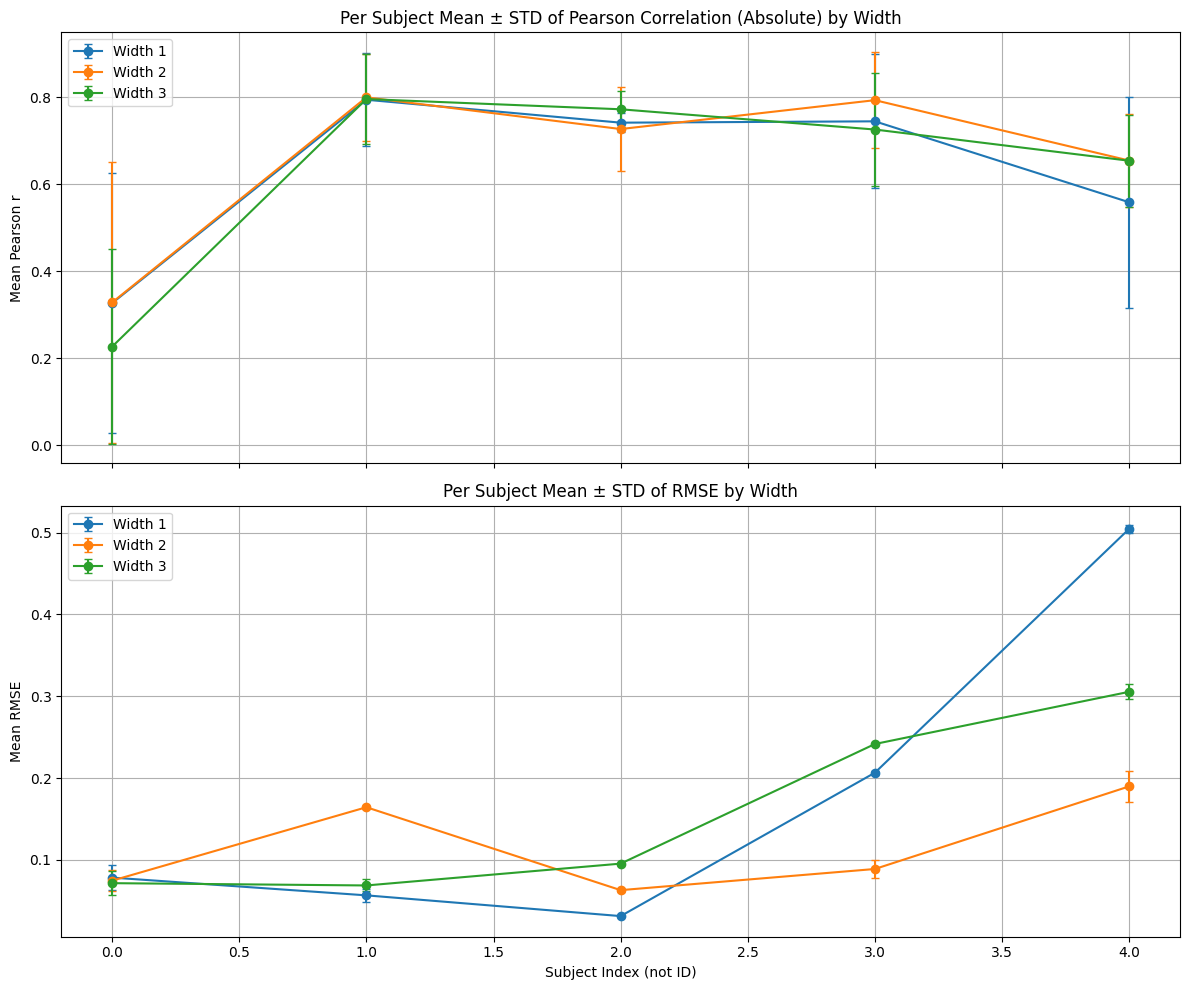

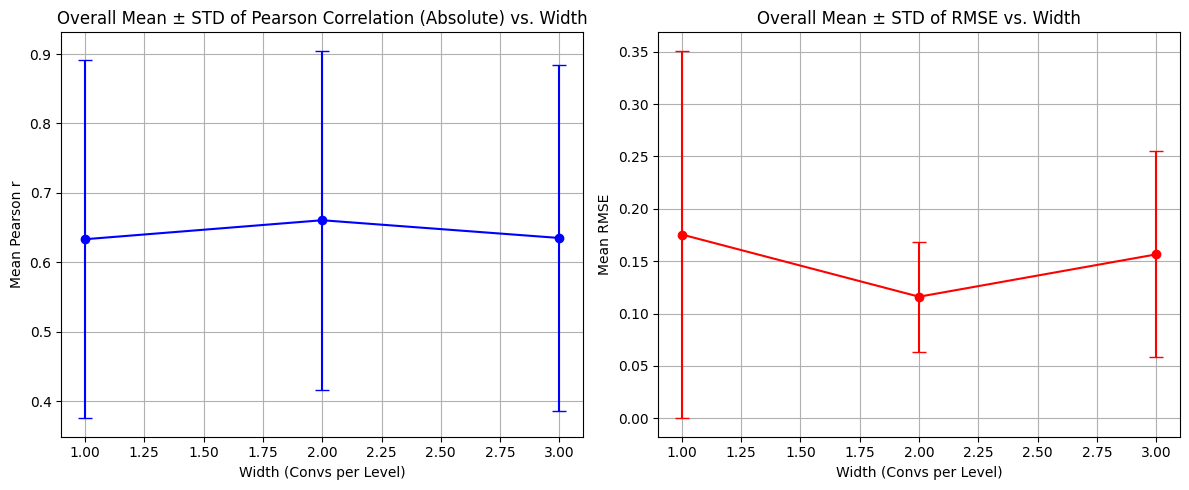

In [5]:
import os
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from models.ecg2ppg_model_width import ECG2PPGps, create_windows, ECG2PPGps_loss
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse

# --- Parameters ---
window_length = 1024
stride = 256
maxEpochs = 500
batchSize = 128
fs = 125
depth = 6
widths = [1, 2, 3]
random_subjects = random.sample(range(1, 54), 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Training and Evaluation ---
for idx in random_subjects:
    file_idx = f"{idx:02d}"
    file_path = f"bidmc_csv/bidmc_{file_idx}_Signals.csv"

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"\n🔵 Processing Subject {file_idx}...")

    try:
        datafile = pd.read_csv(file_path)
        datafile = datafile[['Time [s]', ' II', ' PLETH']]

        ecg = datafile[' II'].to_numpy()
        ecg = remove_baseline_wavelet(ecg)
        ppg = datafile[' PLETH'].to_numpy()
        ppg = remove_baseline_median(ppg, fs)

        if len(ecg) == 0 or len(ppg) == 0 or len(ecg) != len(ppg):
            print(f"Skipping subject {file_idx} due to invalid signals.")
            continue

        ecg_windows = create_windows(ecg, window_length, stride)
        ppg_windows = create_windows(ppg, window_length, stride)

        if len(ecg_windows[-1]) != window_length:
            ecg_windows = ecg_windows[:-1]
        if len(ppg_windows[-1]) != window_length:
            ppg_windows = ppg_windows[:-1]

        num_windows = len(ecg_windows)
        split_idx = int(0.8 * num_windows)
        ecg_train, ecg_test = ecg_windows[:split_idx], ecg_windows[split_idx:]
        ppg_train, ppg_test = ppg_windows[:split_idx], ppg_windows[split_idx:]

        train_dataset = TensorDataset(
            torch.tensor(ppg_train, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_train, dtype=torch.float32).unsqueeze(1)
        )
        test_dataset = TensorDataset(
            torch.tensor(ppg_test, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_test, dtype=torch.float32).unsqueeze(1)
        )

        train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

        for width in widths:
            print(f"Training Subject {file_idx} with Width {width}...")

            # --- Initialize model ---
            model = ECG2PPGps(in_channels=1, out_channels=1, base_channels=24, depth=depth, num_convs_per_level=width).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)

            # --- Training ---
            for epoch in range(maxEpochs):
                model.train()
                for input_batch, target_batch in tqdm(train_loader, desc=f"Subj {file_idx} Width {width} Epoch {epoch+1}", unit="batch", leave=False):
                    input_batch = input_batch.to(device)
                    target_batch = target_batch.to(device)

                    output_batch = model(input_batch)
                    loss = ECG2PPGps_loss(output_batch, target_batch)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            # --- Save model ---
            model_dir = f"subject_models_convs_{width}"
            os.makedirs(model_dir, exist_ok=True)
            model_save_path = os.path.join(model_dir, f"subject_{file_idx}_model.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"💾 Model saved: {model_save_path}")

            # --- Evaluation ---
            model.eval()
            pearson_list = []
            rmse_list = []

            with torch.no_grad():
                for input_batch, target_batch in test_loader:
                    input_batch = input_batch.to(device)
                    output_batch = model(input_batch)

                    output_batch = output_batch.squeeze(1).cpu().numpy()
                    target_batch = target_batch.squeeze(1).cpu().numpy()

                    for i in range(len(output_batch)):
                        pearson = compute_pearson(target_batch[i], output_batch[i])
                        rmse = compute_rmse(target_batch[i], output_batch[i])
                        pearson_list.append(pearson)
                        rmse_list.append(rmse)

            eval_df = pd.DataFrame({
                'Window': np.arange(len(pearson_list)),
                'Pearson_r': pearson_list,
                'RMSE': rmse_list
            })

            eval_save_path = os.path.join(model_dir, f"subject_{file_idx}_evaluation.csv")
            eval_df.to_csv(eval_save_path, index=False)
            print(f"💾 Evaluation saved: {eval_save_path}")

    except Exception as e:
        print(f"❌ Error processing Subject {file_idx}: {e}")

# --- Plotting ---
subject_corr_stats = {width: [] for width in widths}
subject_rmse_stats = {width: [] for width in widths}
global_corr_stats = []
global_rmse_stats = []

for width in widths:
    eval_dir = f"subject_models_convs_{width}"
    all_corrs = []
    all_rmses = []

    for sid in random_subjects:
        eval_path = os.path.join(eval_dir, f"subject_{sid:02d}_evaluation.csv")
        if not os.path.exists(eval_path):
            continue

        df = pd.read_csv(eval_path)
        if "Pearson_r" not in df.columns or "RMSE" not in df.columns:
            continue

        corr_values = np.abs(df["Pearson_r"].dropna().values)
        rmse_values = df["RMSE"].dropna().values

        if len(corr_values) > 0:
            subject_corr_stats[width].append([np.mean(corr_values), np.std(corr_values)])
            all_corrs.extend(corr_values)

        if len(rmse_values) > 0:
            subject_rmse_stats[width].append([np.mean(rmse_values), np.std(rmse_values)])
            all_rmses.extend(rmse_values)

    # Collect global mean/std
    global_corr_stats.append([np.mean(all_corrs), np.std(all_corrs)])
    global_rmse_stats.append([np.mean(all_rmses), np.std(all_rmses)])

# --- Plot 1: Per-Subject Correlation and RMSE ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for width in widths:
    means_corr = [s[0] for s in subject_corr_stats[width]]
    stds_corr = [s[1] for s in subject_corr_stats[width]]
    axs[0].errorbar(range(len(means_corr)), means_corr, yerr=stds_corr, label=f"Width {width}", fmt='o-', capsize=3)

    means_rmse = [s[0] for s in subject_rmse_stats[width]]
    stds_rmse = [s[1] for s in subject_rmse_stats[width]]
    axs[1].errorbar(range(len(means_rmse)), means_rmse, yerr=stds_rmse, label=f"Width {width}", fmt='o-', capsize=3)

axs[0].set_title("Per Subject Mean ± STD of Pearson Correlation (Absolute) by Width")
axs[0].set_ylabel("Mean Pearson r")
axs[0].legend()
axs[0].grid(True)

axs[1].set_title("Per Subject Mean ± STD of RMSE by Width")
axs[1].set_xlabel("Subject Index (not ID)")
axs[1].set_ylabel("Mean RMSE")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# --- Plot 2: Global Summary of Widths ---
width_labels = [str(w) for w in widths]
corr_means = [g[0] for g in global_corr_stats]
corr_stds = [g[1] for g in global_corr_stats]
rmse_means = [g[0] for g in global_rmse_stats]
rmse_stds = [g[1] for g in global_rmse_stats]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].errorbar(widths, corr_means, yerr=corr_stds, fmt='o-', capsize=5, color='blue')
axs[0].set_title("Overall Mean ± STD of Pearson Correlation (Absolute) vs. Width")
axs[0].set_xlabel("Width (Convs per Level)")
axs[0].set_ylabel("Mean Pearson r")
axs[0].grid(True)

axs[1].errorbar(widths, rmse_means, yerr=rmse_stds, fmt='o-', capsize=5, color='red')
axs[1].set_title("Overall Mean ± STD of RMSE vs. Width")
axs[1].set_xlabel("Width (Convs per Level)")
axs[1].set_ylabel("Mean RMSE")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [6]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from models.ecg2ppg_model_6by2 import ECG2PPGps, create_windows, ECG2PPGps_loss
from utils.eval_metrics import compute_pearson, compute_rmse

# --- Parameters ---
window_length = 1024
stride = 256
maxEpochs = 500
batchSize = 128
fs = 125
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Training and Evaluation ---
for idx in range(1, 54):
    file_idx = f"{idx:02d}"
    file_path = f"bidmc_csv/bidmc_{file_idx}_Signals.csv"

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"\n🔵 Processing Subject {file_idx}...")

    try:
        datafile = pd.read_csv(file_path)
        datafile = datafile[['Time [s]', ' II', ' PLETH']]

        ecg = datafile[' II'].to_numpy()
        ecg = remove_baseline_wavelet(ecg)
        ppg = datafile[' PLETH'].to_numpy()
        ppg = remove_baseline_median(ppg, fs)

        if len(ecg) == 0 or len(ppg) == 0 or len(ecg) != len(ppg):
            print(f"Skipping subject {file_idx} due to invalid signals.")
            continue

        ecg_windows = create_windows(ecg, window_length, stride)
        ppg_windows = create_windows(ppg, window_length, stride)

        if len(ecg_windows[-1]) != window_length:
            ecg_windows = ecg_windows[:-1]
        if len(ppg_windows[-1]) != window_length:
            ppg_windows = ppg_windows[:-1]

        num_windows = len(ecg_windows)
        split_idx = int(0.8 * num_windows)
        ecg_train, ecg_test = ecg_windows[:split_idx], ecg_windows[split_idx:]
        ppg_train, ppg_test = ppg_windows[:split_idx], ppg_windows[split_idx:]

        train_dataset = TensorDataset(
            torch.tensor(ppg_train, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_train, dtype=torch.float32).unsqueeze(1)
        )
        test_dataset = TensorDataset(
            torch.tensor(ppg_test, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_test, dtype=torch.float32).unsqueeze(1)
        )

        train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

        # --- Initialize model ---
        model = ECG2PPGps(in_channels=1, out_channels=1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)

        # --- Training ---
        for epoch in range(maxEpochs):
            model.train()
            for input_batch, target_batch in tqdm(train_loader, desc=f"Subj {file_idx} Epoch {epoch+1}", unit="batch", leave=False):
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)

                output_batch = model(input_batch)
                loss = ECG2PPGps_loss(output_batch, target_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

        # --- Save model ---
        model_dir = "subject_models_fixed"
        os.makedirs(model_dir, exist_ok=True)
        model_save_path = os.path.join(model_dir, f"subject_{file_idx}_model.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved: {model_save_path}")

        # --- Evaluation ---
        model.eval()
        results = []

        with torch.no_grad():
            for split_name, loader in [('train', train_loader), ('test', test_loader)]:
                for input_batch, target_batch in loader:
                    input_batch = input_batch.to(device)
                    output_batch = model(input_batch)

                    output_batch = output_batch.squeeze(1).cpu().numpy()
                    target_batch = target_batch.squeeze(1).cpu().numpy()

                    for i in range(len(output_batch)):
                        pearson = compute_pearson(target_batch[i], output_batch[i])
                        rmse = compute_rmse(target_batch[i], output_batch[i])
                        results.append({
                            'Set': split_name,
                            'Window': i,
                            'Pearson_r': pearson,
                            'RMSE': rmse
                        })

        eval_df = pd.DataFrame(results)
        eval_save_path = os.path.join(model_dir, f"subject_{file_idx}_evaluation.csv")
        eval_df.to_csv(eval_save_path, index=False)
        print(f"💾 Evaluation saved: {eval_save_path}")

    except Exception as e:
        print(f"❌ Error processing Subject {file_idx}: {e}")



Using device: cuda

🔵 Processing Subject 01...


💾 Model saved: subject_models_fixed\subject_01_model.pth
💾 Evaluation saved: subject_models_fixed\subject_01_evaluation.csv

🔵 Processing Subject 02...


💾 Model saved: subject_models_fixed\subject_02_model.pth
💾 Evaluation saved: subject_models_fixed\subject_02_evaluation.csv

🔵 Processing Subject 03...


💾 Model saved: subject_models_fixed\subject_03_model.pth
💾 Evaluation saved: subject_models_fixed\subject_03_evaluation.csv

🔵 Processing Subject 04...


💾 Model saved: subject_models_fixed\subject_04_model.pth
💾 Evaluation saved: subject_models_fixed\subject_04_evaluation.csv

🔵 Processing Subject 05...


💾 Model saved: subject_models_fixed\subject_05_model.pth
💾 Evaluation saved: subject_models_fixed\subject_05_evaluation.csv

🔵 Processing Subject 06...


💾 Model saved: subject_models_fixed\subject_06_model.pth
💾 Evaluation saved: subject_models_fixed\subject_06_evaluation.csv

🔵 Processing Subject 07...


💾 Model saved: subject_models_fixed\subject_07_model.pth
💾 Evaluation saved: subject_models_fixed\subject_07_evaluation.csv

🔵 Processing Subject 08...


💾 Model saved: subject_models_fixed\subject_08_model.pth
💾 Evaluation saved: subject_models_fixed\subject_08_evaluation.csv

🔵 Processing Subject 09...


💾 Model saved: subject_models_fixed\subject_09_model.pth
💾 Evaluation saved: subject_models_fixed\subject_09_evaluation.csv

🔵 Processing Subject 10...


💾 Model saved: subject_models_fixed\subject_10_model.pth
💾 Evaluation saved: subject_models_fixed\subject_10_evaluation.csv

🔵 Processing Subject 11...


💾 Model saved: subject_models_fixed\subject_11_model.pth
💾 Evaluation saved: subject_models_fixed\subject_11_evaluation.csv

🔵 Processing Subject 12...


💾 Model saved: subject_models_fixed\subject_12_model.pth
💾 Evaluation saved: subject_models_fixed\subject_12_evaluation.csv

🔵 Processing Subject 13...


💾 Model saved: subject_models_fixed\subject_13_model.pth
💾 Evaluation saved: subject_models_fixed\subject_13_evaluation.csv

🔵 Processing Subject 14...


💾 Model saved: subject_models_fixed\subject_14_model.pth
💾 Evaluation saved: subject_models_fixed\subject_14_evaluation.csv

🔵 Processing Subject 15...


💾 Model saved: subject_models_fixed\subject_15_model.pth
💾 Evaluation saved: subject_models_fixed\subject_15_evaluation.csv

🔵 Processing Subject 16...


💾 Model saved: subject_models_fixed\subject_16_model.pth
💾 Evaluation saved: subject_models_fixed\subject_16_evaluation.csv

🔵 Processing Subject 17...


💾 Model saved: subject_models_fixed\subject_17_model.pth
💾 Evaluation saved: subject_models_fixed\subject_17_evaluation.csv

🔵 Processing Subject 18...


💾 Model saved: subject_models_fixed\subject_18_model.pth
💾 Evaluation saved: subject_models_fixed\subject_18_evaluation.csv

🔵 Processing Subject 19...


💾 Model saved: subject_models_fixed\subject_19_model.pth
💾 Evaluation saved: subject_models_fixed\subject_19_evaluation.csv

🔵 Processing Subject 20...


💾 Model saved: subject_models_fixed\subject_20_model.pth
💾 Evaluation saved: subject_models_fixed\subject_20_evaluation.csv

🔵 Processing Subject 21...


💾 Model saved: subject_models_fixed\subject_21_model.pth
💾 Evaluation saved: subject_models_fixed\subject_21_evaluation.csv

🔵 Processing Subject 22...


💾 Model saved: subject_models_fixed\subject_22_model.pth
💾 Evaluation saved: subject_models_fixed\subject_22_evaluation.csv

🔵 Processing Subject 23...


💾 Model saved: subject_models_fixed\subject_23_model.pth
💾 Evaluation saved: subject_models_fixed\subject_23_evaluation.csv

🔵 Processing Subject 24...


💾 Model saved: subject_models_fixed\subject_24_model.pth
💾 Evaluation saved: subject_models_fixed\subject_24_evaluation.csv

🔵 Processing Subject 25...


💾 Model saved: subject_models_fixed\subject_25_model.pth
💾 Evaluation saved: subject_models_fixed\subject_25_evaluation.csv

🔵 Processing Subject 26...


💾 Model saved: subject_models_fixed\subject_26_model.pth
💾 Evaluation saved: subject_models_fixed\subject_26_evaluation.csv

🔵 Processing Subject 27...


💾 Model saved: subject_models_fixed\subject_27_model.pth
💾 Evaluation saved: subject_models_fixed\subject_27_evaluation.csv

🔵 Processing Subject 28...


💾 Model saved: subject_models_fixed\subject_28_model.pth
💾 Evaluation saved: subject_models_fixed\subject_28_evaluation.csv

🔵 Processing Subject 29...


💾 Model saved: subject_models_fixed\subject_29_model.pth
💾 Evaluation saved: subject_models_fixed\subject_29_evaluation.csv

🔵 Processing Subject 30...


💾 Model saved: subject_models_fixed\subject_30_model.pth
💾 Evaluation saved: subject_models_fixed\subject_30_evaluation.csv

🔵 Processing Subject 31...


💾 Model saved: subject_models_fixed\subject_31_model.pth
💾 Evaluation saved: subject_models_fixed\subject_31_evaluation.csv

🔵 Processing Subject 32...


💾 Model saved: subject_models_fixed\subject_32_model.pth
💾 Evaluation saved: subject_models_fixed\subject_32_evaluation.csv

🔵 Processing Subject 33...


💾 Model saved: subject_models_fixed\subject_33_model.pth
💾 Evaluation saved: subject_models_fixed\subject_33_evaluation.csv

🔵 Processing Subject 34...


💾 Model saved: subject_models_fixed\subject_34_model.pth
💾 Evaluation saved: subject_models_fixed\subject_34_evaluation.csv

🔵 Processing Subject 35...


💾 Model saved: subject_models_fixed\subject_35_model.pth
💾 Evaluation saved: subject_models_fixed\subject_35_evaluation.csv

🔵 Processing Subject 36...


💾 Model saved: subject_models_fixed\subject_36_model.pth
💾 Evaluation saved: subject_models_fixed\subject_36_evaluation.csv

🔵 Processing Subject 37...


💾 Model saved: subject_models_fixed\subject_37_model.pth
💾 Evaluation saved: subject_models_fixed\subject_37_evaluation.csv

🔵 Processing Subject 38...


💾 Model saved: subject_models_fixed\subject_38_model.pth
💾 Evaluation saved: subject_models_fixed\subject_38_evaluation.csv

🔵 Processing Subject 39...


💾 Model saved: subject_models_fixed\subject_39_model.pth
💾 Evaluation saved: subject_models_fixed\subject_39_evaluation.csv

🔵 Processing Subject 40...


💾 Model saved: subject_models_fixed\subject_40_model.pth
💾 Evaluation saved: subject_models_fixed\subject_40_evaluation.csv

🔵 Processing Subject 41...


💾 Model saved: subject_models_fixed\subject_41_model.pth
💾 Evaluation saved: subject_models_fixed\subject_41_evaluation.csv

🔵 Processing Subject 42...


💾 Model saved: subject_models_fixed\subject_42_model.pth
💾 Evaluation saved: subject_models_fixed\subject_42_evaluation.csv

🔵 Processing Subject 43...


💾 Model saved: subject_models_fixed\subject_43_model.pth
💾 Evaluation saved: subject_models_fixed\subject_43_evaluation.csv

🔵 Processing Subject 44...


💾 Model saved: subject_models_fixed\subject_44_model.pth
💾 Evaluation saved: subject_models_fixed\subject_44_evaluation.csv

🔵 Processing Subject 45...


💾 Model saved: subject_models_fixed\subject_45_model.pth
💾 Evaluation saved: subject_models_fixed\subject_45_evaluation.csv

🔵 Processing Subject 46...


💾 Model saved: subject_models_fixed\subject_46_model.pth
💾 Evaluation saved: subject_models_fixed\subject_46_evaluation.csv

🔵 Processing Subject 47...


💾 Model saved: subject_models_fixed\subject_47_model.pth
💾 Evaluation saved: subject_models_fixed\subject_47_evaluation.csv

🔵 Processing Subject 48...


💾 Model saved: subject_models_fixed\subject_48_model.pth
💾 Evaluation saved: subject_models_fixed\subject_48_evaluation.csv

🔵 Processing Subject 49...


💾 Model saved: subject_models_fixed\subject_49_model.pth
💾 Evaluation saved: subject_models_fixed\subject_49_evaluation.csv

🔵 Processing Subject 50...


💾 Model saved: subject_models_fixed\subject_50_model.pth
💾 Evaluation saved: subject_models_fixed\subject_50_evaluation.csv

🔵 Processing Subject 51...


💾 Model saved: subject_models_fixed\subject_51_model.pth
💾 Evaluation saved: subject_models_fixed\subject_51_evaluation.csv

🔵 Processing Subject 52...


💾 Model saved: subject_models_fixed\subject_52_model.pth
💾 Evaluation saved: subject_models_fixed\subject_52_evaluation.csv

🔵 Processing Subject 53...


💾 Model saved: subject_models_fixed\subject_53_model.pth
💾 Evaluation saved: subject_models_fixed\subject_53_evaluation.csv
❌ Error comparing Subject 01: 'Set'
❌ Error comparing Subject 02: 'Set'
❌ Error comparing Subject 03: 'Set'
❌ Error comparing Subject 04: 'Set'
❌ Error comparing Subject 05: 'Set'
❌ Error comparing Subject 06: 'Set'
❌ Error comparing Subject 07: 'Set'
❌ Error comparing Subject 08: 'Set'
❌ Error comparing Subject 09: 'Set'
❌ Error comparing Subject 10: 'Set'
❌ Error comparing Subject 11: 'Set'
❌ Error comparing Subject 12: 'Set'
❌ Error comparing Subject 13: 'Set'
❌ Error comparing Subject 14: 'Set'
❌ Error comparing Subject 15: 'Set'
❌ Error comparing Subject 16: 'Set'
❌ Error comparing Subject 17: 'Set'
❌ Error comparing Subject 18: 'Set'
❌ Error comparing Subject 19: 'Set'
❌ Error comparing Subject 20: 'Set'
❌ Error comparing Subject 21: 'Set'
❌ Error comparing Subject 22: 'Set'
❌ Error comparing Subject 23: 'Set'
❌ Error comparing Subject 24: 'Set'
❌ Error comp

In [9]:
# --- Comparison ---
comparison_results = []


for idx in range(1, 54):
    file_idx = f"{idx:02d}"
    try:
        fixed_path = f"subject_models_fixed/subject_{file_idx}_evaluation.csv"
        previous_path = f"subject_models/subject_{file_idx}_evaluation.csv"

        if not os.path.exists(fixed_path) or not os.path.exists(previous_path):
            continue

        df_fixed = pd.read_csv(fixed_path)
        df_previous = pd.read_csv(previous_path)

        # Merge on Window only
        merged = pd.merge(df_fixed, df_previous, on=['Window'], suffixes=('_fixed', '_prev'))
        merged['Subject'] = idx
        comparison_results.append(merged)

    except Exception as e:
        print(f"❌ Error comparing Subject {file_idx}: {e}")

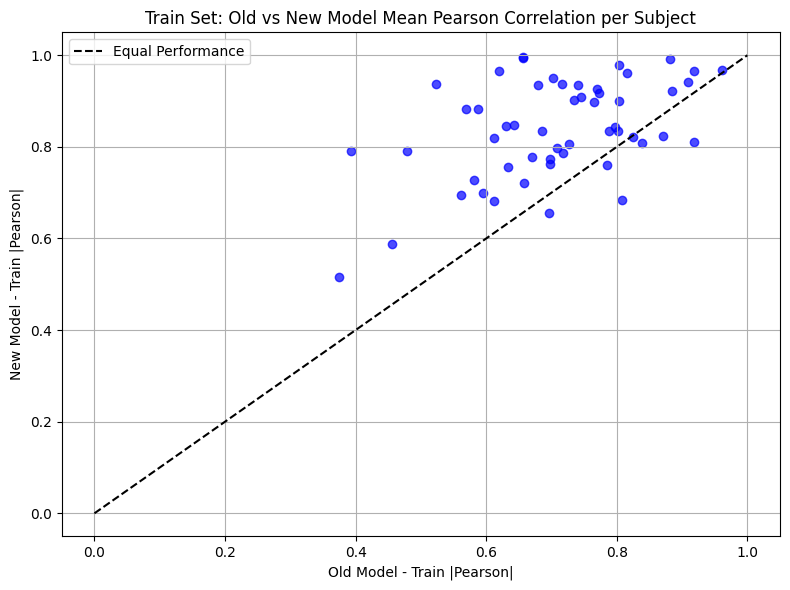

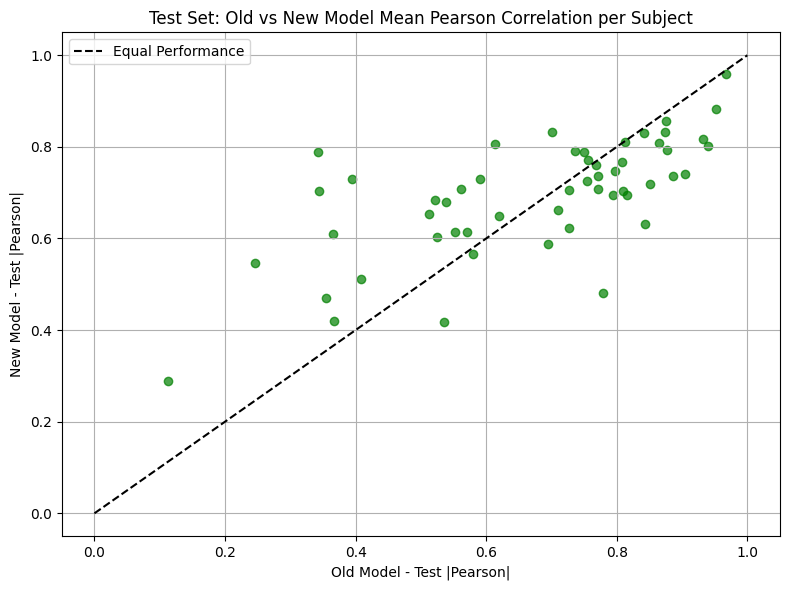

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

subject_ids = range(1, 54)
old_dir = "subject_models"
new_dir = "subject_models_fixed"

summary_data = []

for idx in subject_ids:
    file_idx = f"{idx:02d}"
    old_eval_path = os.path.join(old_dir, f"subject_{file_idx}_evaluation.csv")
    new_eval_path = os.path.join(new_dir, f"subject_{file_idx}_evaluation.csv")

    if not os.path.exists(old_eval_path) or not os.path.exists(new_eval_path):
        continue

    df_old = pd.read_csv(old_eval_path)
    df_new = pd.read_csv(new_eval_path)

    # New model with 'Set' column
    if 'Set' in df_new.columns:
        mean_corr_train_new = np.abs(df_new[df_new['Set'] == 'train']['Pearson_r']).mean()
        mean_corr_test_new = np.abs(df_new[df_new['Set'] == 'test']['Pearson_r']).mean()
    else:
        mean_corr_train_new = np.nan
        mean_corr_test_new = np.nan

    # Old model without 'Set' column
    n_windows = len(df_old)
    split_idx = int(0.8 * n_windows)
    mean_corr_train_old = np.abs(df_old['Pearson_r'][:split_idx]).mean()
    mean_corr_test_old = np.abs(df_old['Pearson_r'][split_idx:]).mean()

    summary_data.append({
        'Subject': idx,
        'Train_Corr_Old': mean_corr_train_old,
        'Test_Corr_Old': mean_corr_test_old,
        'Train_Corr_New': mean_corr_train_new,
        'Test_Corr_New': mean_corr_test_new
    })

summary_df = pd.DataFrame(summary_data)

# --- Scatter Plot: Train ---
plt.figure(figsize=(8, 6))
plt.scatter(summary_df['Train_Corr_Old'], summary_df['Train_Corr_New'],
            color='blue', alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', label='Equal Performance')
plt.xlabel('Old Model - Train |Pearson|')
plt.ylabel('New Model - Train |Pearson|')
plt.title('Train Set: Old vs New Model Mean Pearson Correlation per Subject')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Scatter Plot: Test ---
plt.figure(figsize=(8, 6))
plt.scatter(summary_df['Test_Corr_Old'], summary_df['Test_Corr_New'],
            color='green', alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', label='Equal Performance')
plt.xlabel('Old Model - Test |Pearson|')
plt.ylabel('New Model - Test |Pearson|')
plt.title('Test Set: Old vs New Model Mean Pearson Correlation per Subject')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


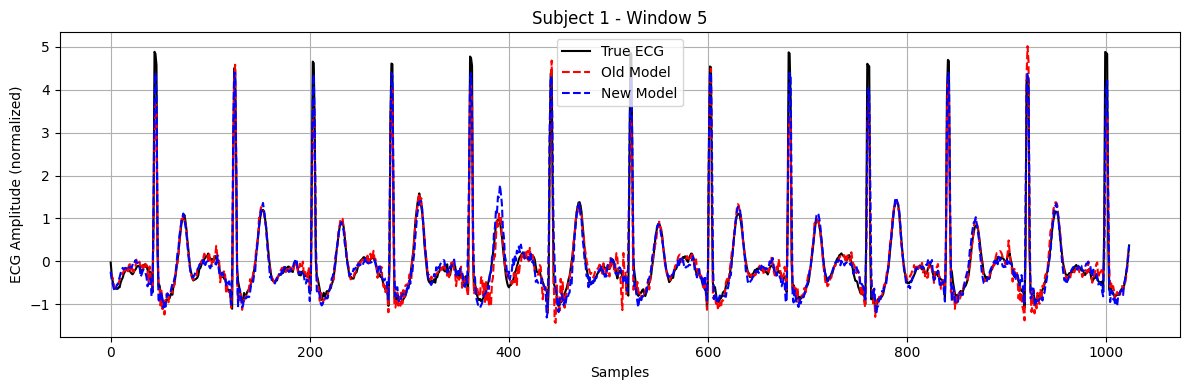

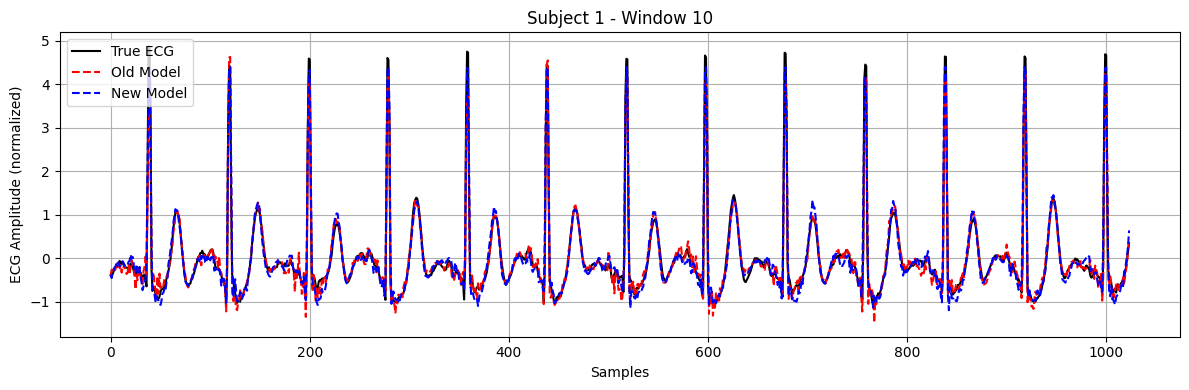

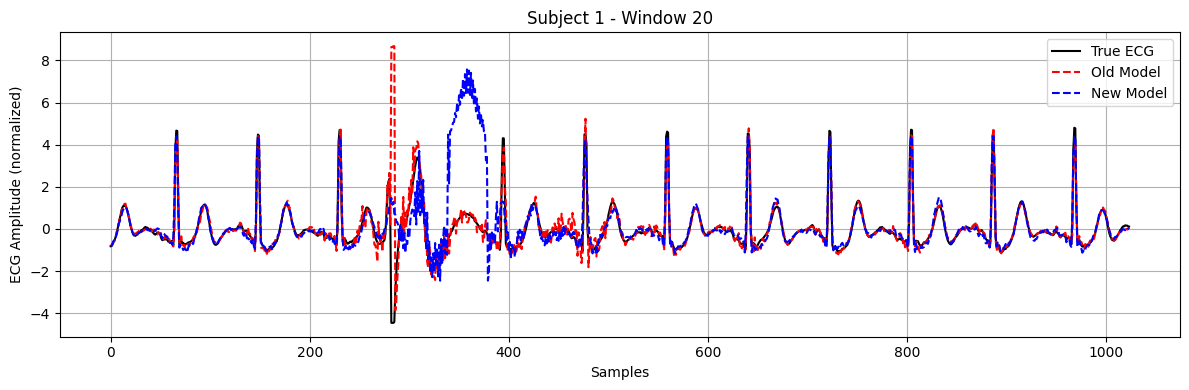

In [21]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.ecg2ppg_model import ECG2PPGps, create_windows
from models.ecg2ppg_model_6by2 import ECG2PPGps as ECG2PPGps_6by2, create_windows


# --- Parameters ---
fs = 125
window_length = 1024
stride = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

subject_id = 1  # Pick a subject to plot

file_idx = f"{subject_id:02d}"
signal_path = f"bidmc_csv/bidmc_{file_idx}_Signals.csv"
if not os.path.exists(signal_path):
    print(f"File not found: {signal_path}")
else:
    # --- Load Data ---
    df = pd.read_csv(signal_path)
    df.columns = [c.strip() for c in df.columns]
    ecg = df['II'].to_numpy()
    ppg = df['PLETH'].to_numpy()

    # --- Baseline Removal ---
    ecg = remove_baseline_wavelet(ecg)
    ppg = remove_baseline_median(ppg, fs)

    # --- Window Data ---
    ecg_windows = create_windows(ecg, window_length, stride)
    ppg_windows = create_windows(ppg, window_length, stride)

    # --- Load Models ---
    model_old_path = f"subject_models/subject_{file_idx}_model.pth"
    model_new_path = f"subject_models_fixed/subject_{file_idx}_model.pth"

    model_old = ECG2PPGps(in_channels=1, out_channels=1).to(device)
    model_old.load_state_dict(torch.load(model_old_path, map_location=device))
    model_old.eval()

    model_new = ECG2PPGps_6by2(in_channels=1, out_channels=1).to(device)
    model_new.load_state_dict(torch.load(model_new_path, map_location=device))
    model_new.eval()

    # --- Reconstruct Full Signals ---
    def reconstruct_signal(model, ppg_windows):
        recon_windows = []
        with torch.no_grad():
            for w in ppg_windows:
                w_tensor = torch.tensor(w[np.newaxis, np.newaxis, :], dtype=torch.float32).to(device)
                recon = model(w_tensor).cpu().squeeze().numpy()
                recon_windows.append(recon)
        # Stitch overlapping windows
        stitched_signal = np.zeros(len(ppg))
        counts = np.zeros(len(ppg))
        for i, w in enumerate(recon_windows):
            start = i * stride
            end = start + window_length
            stitched_signal[start:end] += w
            counts[start:end] += 1
        stitched_signal /= np.maximum(counts, 1)
        return stitched_signal

    reconstructed_old = reconstruct_signal(model_old, ppg_windows)
    reconstructed_new = reconstruct_signal(model_new, ppg_windows)

    # --- Normalize all full signals ---
    true_ecg_norm = (ecg - np.mean(ecg)) / (np.std(ecg) + 1e-8)
    reconstructed_old_norm = (reconstructed_old - np.mean(reconstructed_old)) / (np.std(reconstructed_old) + 1e-8)
    reconstructed_new_norm = (reconstructed_new - np.mean(reconstructed_new)) / (np.std(reconstructed_new) + 1e-8)

    # --- Plot windows after normalization ---
    ecg_windows_norm = create_windows(true_ecg_norm, window_length, stride)
    recon_old_windows = create_windows(reconstructed_old_norm, window_length, stride)
    recon_new_windows = create_windows(reconstructed_new_norm, window_length, stride)

    window_indices = [5, 10, 20]

    for idx in window_indices:
        if idx >= len(ppg_windows):
            continue

        true_ecg = ecg_windows_norm[idx]
        old_output = recon_old_windows[idx]
        new_output = recon_new_windows[idx]

        # --- Plot ---
        plt.figure(figsize=(12, 4))
        plt.plot(true_ecg, label='True ECG', color='black')
        plt.plot(-old_output, label='Old Model', linestyle='--', color='red')
        plt.plot(-new_output, label='New Model', linestyle='--', color='blue')
        plt.title(f'Subject {subject_id} - Window {idx}')
        plt.xlabel('Samples')
        plt.ylabel('ECG Amplitude (normalized)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
